# Imports

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.model_selection import train_test_split # Utilizado para separar dados de treino e teste
from sklearn.preprocessing import StandardScaler # Utilizado para fazer a normalização dos dados
from sklearn.preprocessing import MinMaxScaler # Utilizado para fazer a normalização dos dados
from sklearn.preprocessing import LabelEncoder # Utilizado para fazer o OneHotEncoding
from sklearn.linear_model import LinearRegression # Algoritmo de Regressão Linear
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)

## Data Transformation

In [2]:
def apply_discretization_map(df_new, variable, discretization_map, technique='equal_width', default_bin=-1):
    """
    Aplica o mapeamento de discretização (bins ou thresholds) em novos dados.
    
    Parâmetros:
    - df_new: DataFrame com os novos dados
    - variable: nome da variável a ser discretizada
    - discretization_map: mapeamento com os pontos de corte (bins ou thresholds)
    - technique: técnica usada para a discretização ('equal_width', 'equal_frequency', 'entropy')
    - default_bin: valor padrão a ser atribuído para valores fora do mapeamento (default é -1)
    
    Retorna:
    - df_new: DataFrame com a variável discretizada
    """
    
    if technique in ['equal_width', 'equal_frequency']:
        bins = discretization_map[variable]
        
        # Aplicar a discretização e identificar valores fora dos bins
        df_new[f'{variable}_discretized'] = np.digitize(df_new[variable], bins=bins, right=True) - 1
        
        # Identificar valores fora do intervalo e atribuir um bin padrão (default_bin)
        out_of_bounds_mask = (df_new[variable] < bins[0]) | (df_new[variable] > bins[-1])
        
        if out_of_bounds_mask.any():
            print(f"Erro: Valores de {variable} fora do mapeamento de discretização! "
                  f"Esses valores foram atribuídos ao bin {default_bin}.")
        
        df_new.loc[out_of_bounds_mask, f'{variable}_discretized'] = default_bin
    
    elif technique == 'entropy':
        thresholds = discretization_map['thresholds']
        
        # Aplicar a discretização
        df_new[f'{variable}_discretized'] = np.digitize(df_new[variable], bins=thresholds, right=True)
        
        # Identificar valores fora do intervalo e atribuir um bin padrão
        out_of_bounds_mask = (df_new[variable] < thresholds[0]) | (df_new[variable] > thresholds[-1])
        
        if out_of_bounds_mask.any():
            print(f"Erro: Valores de {variable} fora dos thresholds de discretização! "
                  f"Esses valores foram atribuídos ao bin {default_bin}.")
        
        df_new.loc[out_of_bounds_mask, f'{variable}_discretized'] = default_bin
    
    else:
        raise ValueError("Técnica de discretização inválida. Escolha entre 'equal_width', 'equal_frequency' ou 'entropy'.")
    
    return df_new

def discretize_variable_with_map(df, variable, target=None, technique='equal_width', bins=5):
    """
    Discretiza uma variável contínua de um DataFrame e salva o mapeamento (bins ou thresholds).
    
    Parâmetros:
    - df: DataFrame com os dados
    - variable: nome da coluna que será discretizada
    - target: nome da coluna da variável alvo (necessário para a técnica 'entropy')
    - technique: técnica de discretização ('equal_width', 'equal_frequency', 'entropy')
    - bins: número de intervalos desejados (não aplicável à técnica 'entropy')
    
    Retorna:
    - df: DataFrame com a coluna discretizada
    - discretization_map: mapeamento com os pontos de corte para reutilização em novos dados
    """
    
    discretization_map = {}
    
    if technique == 'equal_width':
        # Discretização por amplitude (equal width)
        df[f'{variable}_discretized'], bin_edges = pd.cut(df[variable], bins=bins, labels=False, retbins=True)
        discretization_map[variable] = bin_edges  
    
    elif technique == 'equal_frequency':
        # Discretização por frequência (equal frequency)
        df[f'{variable}_discretized'], quantile_edges = pd.qcut(df[variable], q=bins, labels=False, retbins=True)
        discretization_map[variable] = quantile_edges  
    
    elif technique == 'entropy':
        # Discretização supervisionada baseada em entropia (árvore de decisão)
        if target is None:
            raise ValueError("A variável alvo ('target') deve ser especificada para a técnica 'entropy'.")
        tree = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=bins)
        tree.fit(df[[variable]], df[target])
        thresholds = tree.tree_.threshold[tree.tree_.threshold != -2]
        df[f'{variable}_discretized'] = np.digitize(df[variable], bins=thresholds, right=True)
        discretization_map[variable] = thresholds  
    
    else:
        raise ValueError("Técnica de discretização inválida. Escolha entre 'equal_width', 'equal_frequency' ou 'entropy'.")
    
    return df, discretization_map

## Load Data

In [3]:
df = pd.read_csv("../datasets/dados_credito_pos_eda.csv")
df.head()

,UF,IDADE,ESCOLARIDADE,ESTADO_CIVIL,QT_FILHOS,CASA_PROPRIA,QT_IMOVEIS,VL_IMOVEIS,OUTRA_RENDA,OUTRA_RENDA_VALOR,TEMPO_ULTIMO_EMPREGO_MESES,TRABALHANDO_ATUALMENTE,ULTIMO_SALARIO,QT_CARROS,VALOR_TABELA_CARROS,SCORE,VLM_IMOVEIS,RENDA_TOTAL,VM_VEICULOS
0,SP,19,Superior Cursando,Solteiro,0,Não,0,0,Não,0,8,Sim,1800.00,0,0,12.00,0.00,1800.00,0.00
1,MG,23,Superior Completo,Solteiro,1,Não,0,0,Não,0,9,Não,4800.00,1,50000,18.00,0.00,0.00,50000.00
2,SC,25,Segundo Grau Completo,Casado,0,Sim,1,220000,Não,0,18,Sim,2200.00,2,30000,23.00,220000.00,2200.00,15000.00
3,PR,27,Superior Cursando,Casado,1,Sim,0,0,Não,0,22,Não,3900.00,0,0,28.67,0.00,0.00,0.00
4,RJ,28,Superior Completo,Divorciado,2,Não,1,370000,Não,0,30,Sim,8287.16,1,35000,34.17,370000.00,8287.16,35000.00


## Train Test Split

Dividir os dados entre treino e teste antes de aplicar o pré-processamento garante que o modelo seja treinado e avaliado de forma justa. Isso evita o vazamento de dados, permitindo que o conjunto de teste simule corretamente novos dados reais.

Esse processo é fundamental para preservar a capacidade do modelo de generalizar adequadamente, que é um dos principais objetivos no aprendizado de máquina.

Como o conjunto de teste será utilizado para avaliar a performance do modelo, ele deve representar novas entradas para a pipeline de dados. Portanto,dividir os dados antes de aplicar transformações como normalização, padronização ou qualquer outra tarefa que dependa de ajustes baseados no conjunto de treinamento.

Isso assegura que os ajustes feitos no pré-processamento reflitam apenas o comportamento dos dados de treino, mantendo o conjunto de teste imparcial.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["SCORE"]), df['SCORE'], test_size = 0.3, random_state = 42)

# Preprocessing

Geralmente as técnicas de pré processamento de dados são aplicadas após a divisão de treino e teste.

É importante salvar o mapeamento dessas transformações, pois elas serão utilizadas nos dados de teste, de modo a simular a entrada de novos dados.

A discretização deve ser feita após o train-test split e apenas nos dados de treino.

Em seguida, você aplica a transformação aos dados de teste utilizando os parâmetros aprendidos no conjunto de treino. 

Isso é importante para evitar o _"data leakage"_ (vazamento de dados), ele ocorre quando informações do conjunto de teste influenciam o treinamento do modelo, resultando em estimativas de desempenho excessivamente otimistas.

## Discretização

A discretização de dados é uma técnica que transforma variáveis contínuas em categorias, dividindo os valores em intervalos ou faixas. Essa abordagem é útil em diversas situações, como:

* Redução da complexidade: Facilita a análise ao converter variáveis contínuas em categorias.
    
* Compatibilidade com modelos: Alguns algoritmos, como os baseados em árvores de decisão, funcionam melhor com variáveis discretas.
    
* Melhor desempenho: Ao reduzir o ruído em dados contínuos, a discretização pode melhorar a precisão dos modelos.

* Facilidade de interpretação: Cria faixas ou grupos que tornam a análise de dados mais acessível.

__Principais Técnicas de Discretização:__


* Discretização por Frequência (Equal Frequency):

        Divide os dados em intervalos que contêm o mesmo número de observações.
        Exemplo: Se houver 100 amostras e 5 intervalos, cada intervalo terá 20 observações.
    
* Discretização por Amplitude (Equal Width):

        Divide os valores contínuos em subintervalos de largura fixa.
        Exemplo: Se os dados variam de 0 a 100 e são criados 5 intervalos, cada um terá uma largura de 20 (0-20, 21-40, etc.).
    
* Discretização Baseada em K-means:

        Usa o algoritmo K-means para agrupar os dados em categorias com base na similaridade.
    
* Discretização Supervisionada (Entropia):

        Maximiza a relação entre a variável contínua e a variável alvo, retendo o máximo de informação.
        Técnicas como ChiMerge e Decision Trees podem ser usadas para determinar os melhores pontos de divisão.
       

> As variáveis 'IDADE' e 'TEMPO_ULTIMO_EMPREGO_MESES' foram discretizadas usando a técnica de Equal Frequency, garantindo que cada intervalo contenha um número equivalente de observações.



Atenção, pode ocorrer que ao interir dados novos, eles possuírem valores que não estão no range de discrtização, por isso, vamos marcar esse valor como -1. Que caso ocorra, precisa ser verificado o que ocorreu e dar a manutenção no modelo desenvolvido.

In [5]:
X_train, map_age = discretize_variable_with_map(X_train, 'IDADE', 'SCORE', technique='equal_frequency', bins=5)
X_train, map_range_employer = discretize_variable_with_map(X_train, 'TEMPO_ULTIMO_EMPREGO_MESES', 'SCORE', technique='equal_frequency', bins=5)
X_train.head()

,UF,IDADE,ESCOLARIDADE,ESTADO_CIVIL,QT_FILHOS,CASA_PROPRIA,QT_IMOVEIS,VL_IMOVEIS,OUTRA_RENDA,OUTRA_RENDA_VALOR,TEMPO_ULTIMO_EMPREGO_MESES,TRABALHANDO_ATUALMENTE,ULTIMO_SALARIO,QT_CARROS,VALOR_TABELA_CARROS,VLM_IMOVEIS,RENDA_TOTAL,VM_VEICULOS,IDADE_discretized,TEMPO_ULTIMO_EMPREGO_MESES_discretized
8037,MG,55,Superior Completo,Divorciado,2,Não,1,370000,Não,0,30,Sim,11500.00,1,35000,370000.00,11500.00,35000.00,3,2
7964,MG,19,Superior Cursando,Solteiro,0,Não,0,0,Não,0,8,Sim,1800.00,0,0,0.00,1800.00,0.00,0,0
6507,PR,27,Superior Cursando,Casado,1,Sim,0,0,Não,0,22,Não,3900.00,0,0,0.00,0.00,0.00,0,2
3443,RJ,62,Superior Cursando,Casado,1,Sim,0,0,Não,0,22,Não,3900.00,0,0,0.00,0.00,0.00,4,2
6096,PR,32,Superior Cursando,Solteiro,0,Sim,1,185000,Sim,3000,19,Sim,6800.00,0,0,185000.00,9800.00,0.00,1,2


## Aply in test data

In [6]:
X_test = apply_discretization_map(X_test, 'IDADE', map_age, 'equal_frequency')
X_test = apply_discretization_map(X_test, 'TEMPO_ULTIMO_EMPREGO_MESES', map_range_employer, 'equal_frequency')

X_train = X_train.drop(columns=['IDADE', 'TEMPO_ULTIMO_EMPREGO_MESES'])
X_test = X_test.drop(columns=['IDADE', 'TEMPO_ULTIMO_EMPREGO_MESES'])
X_train.shape, X_test.shape

((7333, 18), (3143, 18))

## One Hot Encoder


O One Hot Encoder é uma técnica de pré-processamento de dados utilizada para converter variáveis categóricas (qualitativas) em uma forma que possa ser fornecida a algoritmos de machine learning, que geralmente esperam valores numéricos. Ele é amplamente utilizado quando trabalhamos com dados categóricos em problemas de aprendizado supervisionado, como regressão e classificação.


Algoritmos de Machine Learning esperam dados numéricos: A maioria dos algoritmos de machine learning não consegue trabalhar diretamente com dados categóricos, pois eles realizam cálculos matemáticos que exigem números. O One Hot Encoding converte as categorias em um formato binário que facilita esses cálculos.

Evita atribuição de ordens implícitas: Simplesmente substituir categorias por números inteiros (como "Vermelho" = 1, "Verde" = 2, "Azul" = 3) poderia fazer o algoritmo acreditar que existe uma relação de ordem ou magnitude entre as categorias (o que não é o caso). O One Hot Encoding remove essa suposição.

Melhor performance em algoritmos baseados em distâncias: Algoritmos como k-NN e SVM, que utilizam cálculos de distância entre os dados, podem se beneficiar muito mais de variáveis representadas como colunas binárias (em vez de números que podem induzir ordens inadequadas.)

### Quando não utilizar o One Hot Encoding?

* Variáveis com muitas categorias: Se uma variável categórica tiver um grande número de categorias (por exemplo, cidades ou nomes de produtos), o One Hot Encoding criará muitas colunas, resultando em um aumento significativo no número de dimensões do dataset (alta dimensionalidade), o que pode impactar negativamente o desempenho do modelo.

* Algoritmos que lidam bem com dados categóricos: Alguns modelos, como árvores de decisão (e seus derivados, como random forests e gradient boosting), podem lidar diretamente com variáveis categóricas sem a necessidade de One Hot Encoding.


Alternativa ao One Hot Encoding:

_Label Encoding_
    
    Substitui as categorias por números inteiros, mas pode introduzir uma ordem implícita.

In [7]:
def one_hot_encode(df, column):
    """
    Função que realiza One-Hot Encoding de uma coluna e retorna o DataFrame com as colunas dummies,
    juntamente com o mapeamento das colunas (categorias).
    """
    df_encoded = pd.get_dummies(df, columns=[column], drop_first=True)
    
    # Mapeamento das categorias para colunas
    encoder_map = {category: col_name for col_name, category in zip(df_encoded.columns, df_encoded.columns) if col_name.startswith(column)}
    
    return df_encoded, encoder_map

def label_encoder(df, variable):
    """
    Aplica o Label Encoding a uma variável categórica em um DataFrame.
    
    Parâmetros:
    - df: DataFrame que contém a coluna a ser codificada.
    - variable: Nome da coluna a ser codificada.
    
    Retorna:
    - DataFrame com a coluna codificada.
    - Dicionário de mapeamento (categoria para valor numérico).
    """
    categories = df[variable].unique()
    
    # Criar mapeamento das categorias para números
    label_mapping = {category: idx for idx, category in enumerate(categories)}
    
    # Aplicar o mapeamento diretamente na coluna
    df[variable] = df[variable].map(label_mapping)
    
    return df, label_mapping

def apply_encoding(df, column, encoding_map, encoding_type, default_value=None):
    """
    Aplica One-Hot Encoding ou Label Encoding com base no tipo de codificação passado.
    
    Parâmetros:
    - df: DataFrame que contém a coluna a ser codificada.
    - column: Nome da coluna a ser codificada.
    - encoding_map: Dicionário com o mapeamento de codificação.
    - encoding_type: Tipo de codificação ('onehot' ou 'label').
    - default_value: Valor padrão a ser atribuído para valores não mapeados.
    
    Retorna:
    - DataFrame com a coluna codificada.
    """
    if encoding_type == 'label':
        # Se default_value for None, forneça um valor padrão
        if default_value is None:
            default_value = -1  # ou outro valor que faça sentido para o seu contexto
        
        # Aplicar o mapeamento, e valores fora do mapa recebem o valor default
        df[column] = df[column].map(encoding_map).fillna(default_value)
        
    elif encoding_type == 'onehot':
        # Para One-Hot Encoding, geramos colunas de acordo com o mapeamento existente
        for col, map_col in encoding_map.items():
            df[map_col] = (df[column] == col.split('_')[1]).astype(int)
    else:
        raise ValueError("Tipo de codificação inválido. Escolha 'onehot' ou 'label'.")
    
    return df

In [8]:
cat_vars = df.select_dtypes(include=['object', 'category']).columns.to_list()
cat_vars 

['UF',
 'ESCOLARIDADE',
 'ESTADO_CIVIL',
 'CASA_PROPRIA',
 'OUTRA_RENDA',
 'TRABALHANDO_ATUALMENTE']

In [9]:
X_train, encoder_uf = label_encoder(X_train, 'UF')
X_train, encoder_escolaridade = label_encoder(X_train, 'ESCOLARIDADE')
X_train, encoder_estado_civil = label_encoder(X_train, 'ESTADO_CIVIL')
X_train, encoder_casa_propria = label_encoder(X_train, 'CASA_PROPRIA')
X_train, encoder_outra_renda = label_encoder(X_train, 'OUTRA_RENDA')
X_train, encoder_trabalhando_atualmente = label_encoder(X_train, 'TRABALHANDO_ATUALMENTE')

## Aply in test data

In [10]:
X_test = apply_encoding(X_test, 'UF', encoder_uf, 'label')
X_test = apply_encoding(X_test, 'ESCOLARIDADE', encoder_escolaridade,'label')
X_test = apply_encoding(X_test, 'ESTADO_CIVIL', encoder_estado_civil, 'label')
X_test = apply_encoding(X_test, 'CASA_PROPRIA', encoder_casa_propria,'label')
X_test = apply_encoding(X_test, 'OUTRA_RENDA', encoder_outra_renda, 'label')
X_test = apply_encoding(X_test, 'TRABALHANDO_ATUALMENTE', encoder_trabalhando_atualmente, 'label')
X_train.shape, X_test.shape

((7333, 18), (3143, 18))

## Scale

Deixar os dados na mesma escala refere-se ao processo de ajustar os valores numéricos de diferentes variáveis para que estejam no mesmo intervalo ou faixa, ou tenham uma variação semelhante. Isso é importante porque alguns algoritmos de Aprendizado de Máquina são sensíveis à escala dos dados e podem se beneficiar de variáveis que estão padronizadas ou normalizadas.
_______________________________________________________________________________________________________________________
**Padronização**

A padronização (ou standardization) transforma os dados para que tenham média 0 e desvio padrão 1. Isso significa que os valores ajustados de cada variável estarão centrados em torno da média e medidos em termos de unidades de desvio padrão.

_______________________________________________________________________________________________________________________
**Normalização**

A normalização (ou min-max scaling) transforma os dados para que todos os valores estejam dentro de um intervalo específico, normalmente entre 0 e 1. Isso é feito ajustando a escala dos valores da variável.

_________________________________________________________________________________________________________________________
<p align="center"><strong>TABELA RESUMO<strong></p>

_________________________________________________________________________________________________________________________

| Característica             | Padronização                                           | Normalização                                        |
|----------------------------|-------------------------------------------------------|----------------------------------------------------|
| Definição                   | Ajusta os dados para terem média 0 e desvio padrão 1.  | Ajusta os dados para estarem em um intervalo específico (geralmente de 0 a 1). |
| Quando aplicar              | Útil para algoritmos que assumem uma distribuição gaussiana (normal), como regressão linear, SVM, KNN. | Útil para algoritmos que utilizam gradientes, como redes neurais e algoritmos de otimização. |
| Impacto                     | Algoritmos que dependem de medidas de distância ou gradientes se beneficiam da padronização. | Evita que variáveis com diferentes escalas afetem o processo de treinamento.  |
| Exemplos de uso             | Regressão linear, K-Nearest Neighbors (KNN), Support Vector Machines (SVM). | Redes neurais, k-means, regressão logística.        |


In [11]:
def scale_data(df, columns, method='minmax'):
    """
    Função que normaliza ou padroniza colunas específicas de um DataFrame usando MinMaxScaler ou StandardScaler
    do scikit-learn, mantendo as demais colunas intactas.
    
    Parâmetros:
    - df: DataFrame com os dados
    - columns: lista de colunas a serem escaladas
    - method: método de escalonamento ('minmax' ou 'standard')
    
    Retorna:
    - df_scaled: DataFrame completo com as colunas especificadas escaladas
    - scaler: objeto scaler (MinMaxScaler ou StandardScaler) com os parâmetros salvos
    """
    df_scaled = df.copy()
    
    if method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("Método inválido. Escolha entre 'minmax' ou 'standard'.")

    df_scaled[columns] = scaler.fit_transform(df[columns])
    
    return df_scaled, scaler

def apply_scaling(df_new, columns, scaler):
    """
    Aplica a normalização ou padronização a novas colunas específicas usando o scaler já ajustado,
    mantendo as demais colunas intactas.
    
    Parâmetros:
    - df_new: DataFrame com os novos dados
    - columns: lista de colunas a serem escaladas
    - scaler: objeto scaler (MinMaxScaler ou StandardScaler) ajustado com os dados originais
    
    Retorna:
    - df_new_scaled: DataFrame completo com as colunas especificadas escaladas
    """

    df_new_scaled = df_new.copy()

    df_new_scaled[columns] = scaler.transform(df_new[columns])
    
    return df_new_scaled

In [12]:
num_cols = X_train.select_dtypes(include=['int', 'float']).columns.to_list()
num_cols 

['UF',
 'ESCOLARIDADE',
 'ESTADO_CIVIL',
 'QT_FILHOS',
 'CASA_PROPRIA',
 'QT_IMOVEIS',
 'VL_IMOVEIS',
 'OUTRA_RENDA',
 'OUTRA_RENDA_VALOR',
 'TRABALHANDO_ATUALMENTE',
 'ULTIMO_SALARIO',
 'QT_CARROS',
 'VALOR_TABELA_CARROS',
 'VLM_IMOVEIS',
 'RENDA_TOTAL',
 'VM_VEICULOS',
 'IDADE_discretized',
 'TEMPO_ULTIMO_EMPREGO_MESES_discretized']

In [13]:
X_train_scaled, scaler_x = scale_data(X_train, num_cols, method='standard')
X_test_scaled = apply_scaling(X_test, num_cols, scaler_x)
X_train_scaled.describe()

,UF,ESCOLARIDADE,ESTADO_CIVIL,QT_FILHOS,CASA_PROPRIA,QT_IMOVEIS,VL_IMOVEIS,OUTRA_RENDA,OUTRA_RENDA_VALOR,TRABALHANDO_ATUALMENTE,ULTIMO_SALARIO,QT_CARROS,VALOR_TABELA_CARROS,VLM_IMOVEIS,RENDA_TOTAL,VM_VEICULOS,IDADE_discretized,TEMPO_ULTIMO_EMPREGO_MESES_discretized
count,7333.00,7333.00,7333.00,7333.00,7333.00,7333.00,7333.00,7333.00,7333.00,7333.00,7333.00,7333.00,7333.00,7333.00,7333.00,7333.00,7333.00,7333.00
mean,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.60,-1.18,-1.42,-1.14,-0.92,-0.88,-0.89,-0.50,-0.49,-0.79,-1.11,-1.16,-0.86,-1.03,-0.83,-0.84,-1.37,-1.38
25%,-0.82,-1.18,-1.42,-1.14,-0.92,-0.88,-0.89,-0.50,-0.49,-0.79,-0.75,-1.16,-0.86,-1.03,-0.83,-0.84,-0.64,-0.66
50%,-0.05,0.05,-0.32,-0.11,-0.92,0.17,-0.19,-0.50,-0.49,-0.79,-0.37,0.07,-0.12,0.17,-0.36,-0.31,0.09,0.07
75%,0.73,1.29,0.77,0.92,1.09,0.17,0.51,-0.50,-0.49,1.26,0.57,1.31,0.19,0.91,0.64,0.48,0.82,0.79
max,1.51,1.29,1.87,1.95,1.09,2.29,2.52,1.99,2.59,1.26,2.38,1.31,2.94,1.88,2.84,3.14,1.56,1.51


In [14]:
X_test_scaled.isnull().sum()

UF                                        0
ESCOLARIDADE                              0
ESTADO_CIVIL                              0
QT_FILHOS                                 0
CASA_PROPRIA                              0
QT_IMOVEIS                                0
VL_IMOVEIS                                0
OUTRA_RENDA                               0
OUTRA_RENDA_VALOR                         0
TRABALHANDO_ATUALMENTE                    0
ULTIMO_SALARIO                            0
QT_CARROS                                 0
VALOR_TABELA_CARROS                       0
VLM_IMOVEIS                               0
RENDA_TOTAL                               0
VM_VEICULOS                               0
IDADE_discretized                         0
TEMPO_ULTIMO_EMPREGO_MESES_discretized    0
dtype: int64

## Models

In [15]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import seaborn as sns

def create_linear_regression_sklearn(X_train, y_train):
    """
    Cria e treina um modelo de Regressão Linear.
    
    Parâmetros:
    - X_train: Dados de treino para as features.
    - y_train: Dados de treino para o target.
    
    Retorna:
    - model: Modelo de Regressão Linear treinado.
    """
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)
    return model

def create_ridge_sklearn(X_train, y_train, alpha=1.0):
    """
    Cria e treina um modelo de Regressão Ridge.
    
    Parâmetros:
    - X_train: Dados de treino para as features.
    - y_train: Dados de treino para o target.
    - alpha: Parâmetro de regularização (default é 1.0).
    
    Retorna:
    - model: Modelo de Regressão Ridge treinado.
    """
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    return model

def predict_models(X_test, model):
    """
    Faz previsões com um modelo treinado.
    
    Parâmetros:
    - X_test: Dados para fazer previsões.
    - model: Modelo treinado.
    
    Retorna:
    - predicted: Previsões feitas pelo modelo.
    """
    predicted = model.predict(X_test)
    return predicted

def regression_metrics(name_model, y_true, y_pred):
    """
    Calcula e retorna as principais métricas de regressão linear.
    
    :param y_true: Valores reais
    :param y_pred: Valores preditos
    :return: DataFrame com as métricas
    """
    # Cálculo das métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)
    
    # Criação do DataFrame com as métricas
    metrics_df = pd.DataFrame({
        'metrics': ['MAE', 'MSE', 'RMSE', 'R²'],
        'value_metrics': [mae, mse, rmse, r2]
    })
    
    metrics_df['name_model'] = name_model

    return metrics_df

def plot_residuals_vs_predictions(y_true, y_pred):
    """
    Plota os resíduos vs os valores preditos.
    
    :param y_true: Valores reais
    :param y_pred: Valores preditos
    :return: Figura com o gráfico
    """
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', lw=2)
    plt.xlabel('Valores Preditos')
    plt.ylabel('Resíduos')
    plt.title('Resíduos vs Valores Preditos')
    plt.show()
    return plt.gcf()

def plot_residuals_distribution(residuals):
    """
    Plota a distribuição dos resíduos.
    
    :param residuals: Resíduos (diferença entre valores reais e preditos)
    :return: Figura com o gráfico
    """
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title('Distribuição dos Resíduos')
    plt.xlabel('Resíduos')
    plt.show()
    return plt.gcf()

def plot_real_vs_predicted(y_true, y_pred):
    """
    Plota os valores reais vs valores preditos.
    
    :param y_true: Valores reais
    :param y_pred: Valores preditos
    :return: Figura com o gráfico
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', lw=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Preditos')
    plt.title('Valores Reais vs Valores Preditos')
    plt.show()
    return plt.gcf()

def plot_absolute_errors(y_true, y_pred):
    """
    Plota a distribuição dos erros absolutos.
    
    :param y_true: Valores reais
    :param y_pred: Valores preditos
    :return: Figura com o gráfico
    """
    residuals = y_true - y_pred
    absolute_errors = abs(residuals)
    plt.figure(figsize=(8, 6))
    sns.histplot(absolute_errors, kde=True, bins=30)
    plt.title('Distribuição dos Erros Absolutos')
    plt.xlabel('Erro Absoluto')
    plt.show()
    return plt.gcf()

ModuleNotFoundError: No module named 'matplotlib'

In [13]:
# não esquecer de tratar os -1 de erro depois :)
model_linear = create_linear_regression_sklearn(X_train_scaled, y_train)
y_pred_linear = predict_models(X_test_scaled, model_linear)

metrics_df_linear = regression_metrics('linear_regression', y_test, y_pred_linear)
print(metrics_df_linear)

  metrics  value_metrics         name_model
0     MAE           6.09  linear_regression
1     MSE          51.61  linear_regression
2    RMSE           7.18  linear_regression
3      R²           0.93  linear_regression


: 

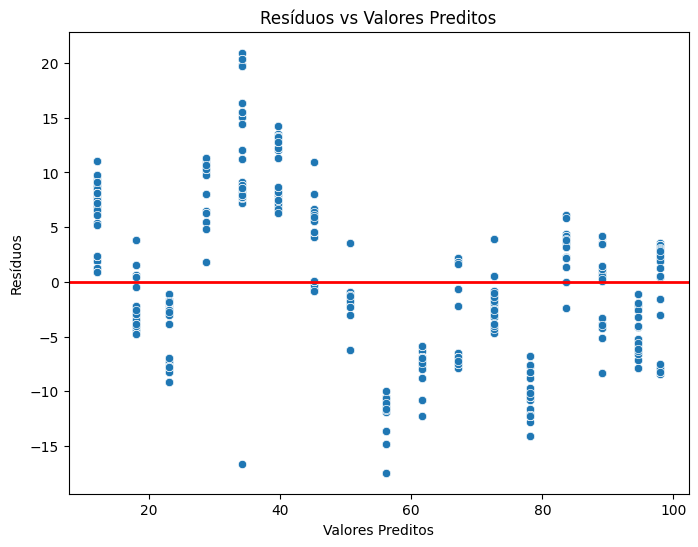

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

: 

In [14]:
plot_residuals_vs_predictions(y_pred_linear, y_test)

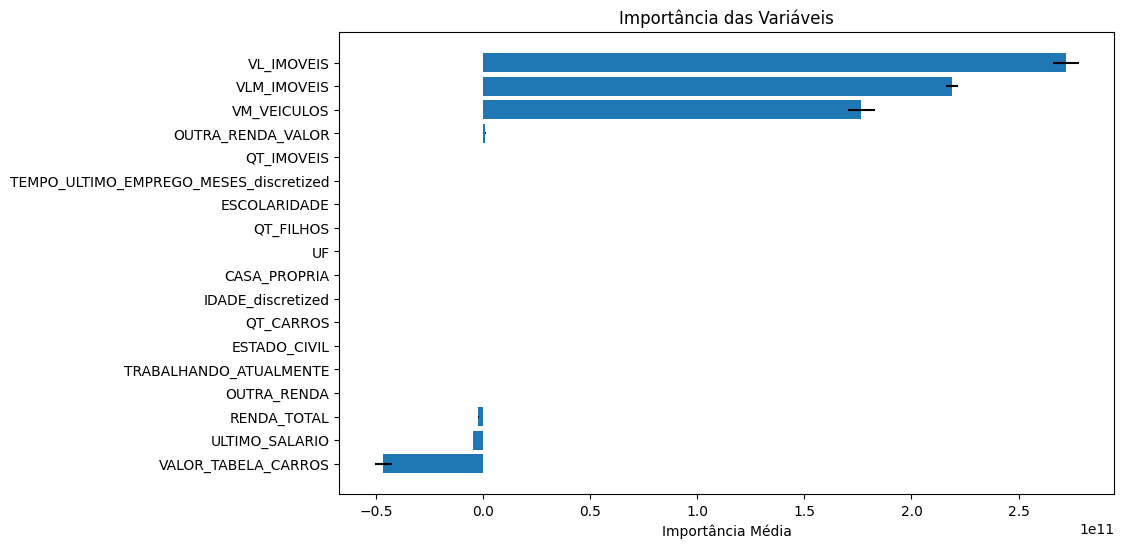

: 

In [16]:
def plot_feature_importances(X_test, y_test, model, feature_names, explainer_type='permutation', lime_explainer=None):
    """
    Plota a importância das variáveis usando permutação, LIME ou SHAP.
    
    Parâmetros:
    - X_test: Dados de teste para as features.
    - y_test: Dados de teste para o target.
    - model: Modelo treinado.
    - feature_names: Lista com os nomes das variáveis/features.
    - explainer_type: Tipo de explicador a ser usado ('permutation', 'lime' ou 'shap').
    - lime_explainer: Explicador LIME (se aplicável).
    """
    plt.figure(figsize=(12, 8))
    
    if explainer_type == 'permutation':
        # Calcule a importância por permutação
        result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)
        importances = result.importances_mean
        std = result.importances_std
        indices = importances.argsort()
        plt.title("Importância das Variáveis - Permutação")
        plt.barh(range(len(importances)), importances[indices], xerr=std[indices], align="center")
        plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
        plt.xlabel("Importância Média")
    
    elif explainer_type == 'lime':
        # Verifique se o explicador LIME foi fornecido
        if lime_explainer is None:
            raise ValueError("Explicador LIME deve ser fornecido para o tipo de explicador 'lime'.")
        # Explique a previsão do modelo usando LIME
        explanation = lime_explainer.explain_instance(X_test[0], model.predict_proba)
        feature_importances = np.array([x[1] for x in explanation.as_list()])
        features = np.array([x[0] for x in explanation.as_list()])
        plt.title("Importância das Variáveis - LIME")
        plt.barh(features, feature_importances, align="center")
        plt.xlabel("Importância")
    
    elif explainer_type == 'shap':
        # Calcule a importância usando SHAP
        explainer = shap.Explainer(model, X_test)
        shap_values = explainer(X_test)
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")
        plt.title("Importância das Variáveis - SHAP")
    
    else:
        raise ValueError("Tipo de explicador inválido. Escolha 'permutation', 'lime' ou 'shap'.")
    
    plt.show()

: 

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import shap
from sklearn.inspection import permutation_importance
from lime.lime_tabular import LimeTabularExplainer

def plot_feature_importances(X_test, y_test, model, feature_names, explainer_type='permutation', lime_explainer=None):
    """
    Plota a importância das variáveis usando permutação, LIME ou SHAP.
    
    Parâmetros:
    - X_test: Dados de teste para as features.
    - y_test: Dados de teste para o target.
    - model: Modelo treinado.
    - feature_names: Lista com os nomes das variáveis/features.
    - explainer_type: Tipo de explicador a ser usado ('permutation', 'lime' ou 'shap').
    - lime_explainer: Explicador LIME (se aplicável).
    """
    plt.figure(figsize=(12, 8))
    
    if explainer_type == 'permutation':
        # Calcule a importância por permutação
        result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)
        importances = result.importances_mean
        std = result.importances_std
        indices = importances.argsort()
        plt.title("Importância das Variáveis - Permutação")
        plt.barh(range(len(importances)), importances[indices], xerr=std[indices], align="center")
        plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
        plt.xlabel("Importância Média")
    
    elif explainer_type == 'lime':
        # Verifique se o explicador LIME foi fornecido
        if lime_explainer is None:
            raise ValueError("Explicador LIME deve ser fornecido para o tipo de explicador 'lime'.")
        # Explique a previsão do modelo usando LIME
        explanation = lime_explainer.explain_instance(X_test[0], model.predict_proba)
        feature_importances = np.array([x[1] for x in explanation.as_list()])
        features = np.array([x[0] for x in explanation.as_list()])
        plt.title("Importância das Variáveis - LIME")
        plt.barh(features, feature_importances, align="center")
        plt.xlabel("Importância")
    
    elif explainer_type == 'shap':
        # Calcule a importância usando SHAP
        explainer = shap.Explainer(model, X_test)
        shap_values = explainer(X_test)
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")
        plt.title("Importância das Variáveis - SHAP")
    
    else:
        raise ValueError("Tipo de explicador inválido. Escolha 'permutation', 'lime' ou 'shap'.")
    
    plt.show()

# Exemplo de uso com cada tipo de explicador
# Crie um explicador LIME (necessário para o tipo 'lime')
lime_explainer = LimeTabularExplainer(X_test.values, feature_names=X_test_scaled.columns, mode='classification')

# Exemplo com permutação
plot_feature_importances(X_test, y_test, model_linear, feature_names, explainer_type='permutation')

# Exemplo com LIME
plot_feature_importances(X_test, y_test, model_linear, feature_names, explainer_type='lime', lime_explainer=lime_explainer)

# Exemplo com SHAP
plot_feature_importances(X_test, y_test, model_linear, feature_names, explainer_type='shap')


ModuleNotFoundError: No module named 'shap'

: 

In [162]:
from sklearn.linear_model import LinearRegression


linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

y_pred_linear = linear_model.predict(X_test_scaled)



  metrics  value_metrics         name_model
0     MAE           6.09  linear_regression
1     MSE          51.61  linear_regression
2    RMSE           7.18  linear_regression
3      R²           0.93  linear_regression


: 

: 

### Metrics 

As métricas de avaliação são utilizadas para medir a precisão de um modelo. 

Neste caso para modelos de Regressão, temos as seguintes métricas: 

1. Mean Absolute Error (MAE)

O MAE (Erro Médio Absoluto) mede a média das diferenças absolutas entre os valores reais e os valores previstos pelo modelo. Ou seja, ele diz em média o quanto o modelo está errando, sem levar em conta a direção (para cima ou para baixo).


O MAE ajuda a medir o erro médio entre o score de crédito real e o score previsto. Um MAE de 10, por exemplo, significa que, em média, o modelo está errando em 10 pontos no score de crédito de um cliente.

> Impacto no negócio: Se o MAE for alto, isso significa que o modelo está cometendo erros significativos na previsão do score de crédito, o que pode resultar em avaliações incorretas de risco de crédito. Quanto menor o MAE, mais precisas são as previsões, levando a melhores decisões na aprovação de crédito.

2. Mean Squared Error (MSE)

O MSE (Erro Quadrático Médio) é a média dos quadrados das diferenças entre os valores reais e os valores previstos. Ele dá mais peso a grandes erros por causa do quadrado, sendo útil quando você quer penalizar desvios maiores.


O MSE também mede o erro entre o score real e o previsto, mas o quadrado das diferenças torna a métrica mais sensível a grandes desvios.

> Impacto no negócio: Se houver outliers (clientes cujos scores estão sendo muito mal previstos), o MSE vai destacá-los. Um MSE alto pode indicar que o modelo está falhando em prever corretamente os scores de certos clientes, potencialmente levando a decisões arriscadas para clientes com pontuações extremas.

3. R² Score (Coeficiente de Determinação)

O R² mede a proporção da variabilidade total nos valores reais que é explicada pelo modelo. Ele vai de 0 a 1 (embora possa ser negativo em casos de modelos muito ruins), onde:

 * 1 significa que o modelo explica toda a variabilidade dos dados.
 * 0 significa que o modelo não explica nada além da média dos dados.

O R² indica quanto do comportamento do score de crédito o modelo consegue explicar. Um R² de 0.75, por exemplo, significa que o modelo explica 75% da variabilidade do score de crédito, e o restante de 25% é explicado por outros fatores não capturados pelo modelo.

> Impacto no negócio: Um R² alto significa que o modelo é bom em prever o score de crédito e, portanto, será útil para tomadas de decisões como concessão de crédito, taxas de juros ajustadas ao risco e classificação de clientes. Se o R² for baixo, o modelo pode não estar capturando adequadamente os fatores que influenciam o score, o que pode levar a decisões erradas de crédito.

In [161]:
def regression_metrics(name_model, y_true, y_pred):
    """
    Calcula e retorna as principais métricas de regressão linear.
    
    :param y_true: Valores reais
    :param y_pred: Valores preditos
    :return: DataFrame com as métricas
    """
    # Cálculo das métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)
    
    # Criação do DataFrame com as métricas
    metrics_df = pd.DataFrame({
        'metrics': ['MAE', 'MSE', 'RMSE', 'R²'],
        'value_metrics': [mae, mse, rmse, r2]
    })
    
    metrics_df['name_model'] = name_model

    return metrics_df

def plot_residuals_vs_predictions(y_true, y_pred):
    """
    Plota os resíduos vs os valores preditos.
    
    :param y_true: Valores reais
    :param y_pred: Valores preditos
    :return: Figura com o gráfico
    """
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', lw=2)
    plt.xlabel('Valores Preditos')
    plt.ylabel('Resíduos')
    plt.title('Resíduos vs Valores Preditos')
    plt.show()
    return plt.gcf()

def plot_residuals_distribution(residuals):
    """
    Plota a distribuição dos resíduos.
    
    :param residuals: Resíduos (diferença entre valores reais e preditos)
    :return: Figura com o gráfico
    """
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title('Distribuição dos Resíduos')
    plt.xlabel('Resíduos')
    plt.show()
    return plt.gcf()

def plot_real_vs_predicted(y_true, y_pred):
    """
    Plota os valores reais vs valores preditos.
    
    :param y_true: Valores reais
    :param y_pred: Valores preditos
    :return: Figura com o gráfico
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', lw=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Preditos')
    plt.title('Valores Reais vs Valores Preditos')
    plt.show()
    return plt.gcf()

def plot_absolute_errors(y_true, y_pred):
    """
    Plota a distribuição dos erros absolutos.
    
    :param y_true: Valores reais
    :param y_pred: Valores preditos
    :return: Figura com o gráfico
    """
    residuals = y_true - y_pred
    absolute_errors = abs(residuals)
    plt.figure(figsize=(8, 6))
    sns.histplot(absolute_errors, kde=True, bins=30)
    plt.title('Distribuição dos Erros Absolutos')
    plt.xlabel('Erro Absoluto')
    plt.show()
    return plt.gcf()


: 

: 

In [ ]:
from sklearn.linear_model import Ridge


ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

y_pred_ridge = ridge_model.predict(X_test_scaled)

metrics_df = regression_metrics( 'ridge', y_test, y_pred_ridge)
metrics_df


,metrics,value_metrics,name_model
0,MAE,0.07,ridge
1,MSE,0.01,ridge
2,RMSE,0.09,ridge
3,R²,0.91,ridge


: 

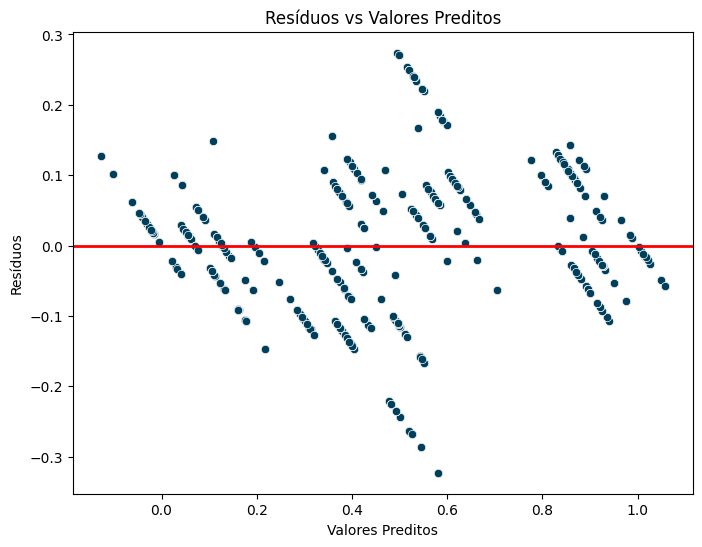

<Figure size 640x480 with 0 Axes>

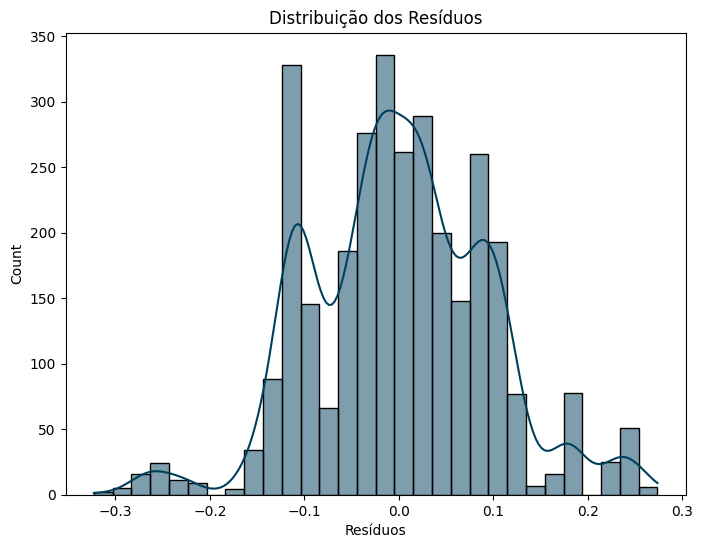

<Figure size 640x480 with 0 Axes>

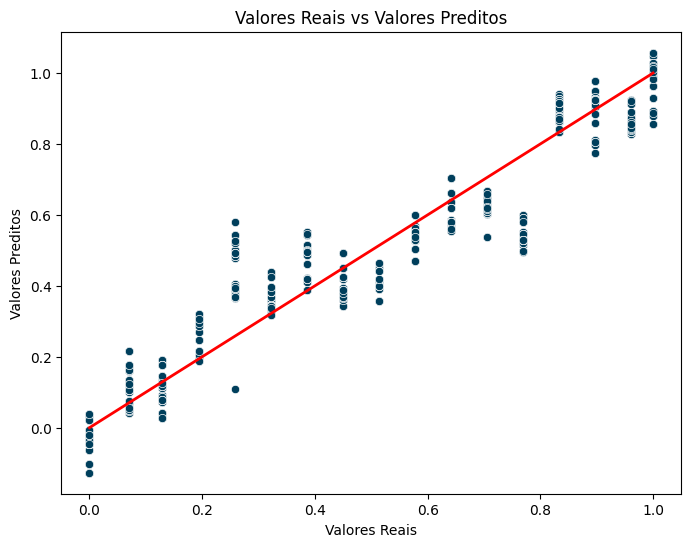

<Figure size 640x480 with 0 Axes>

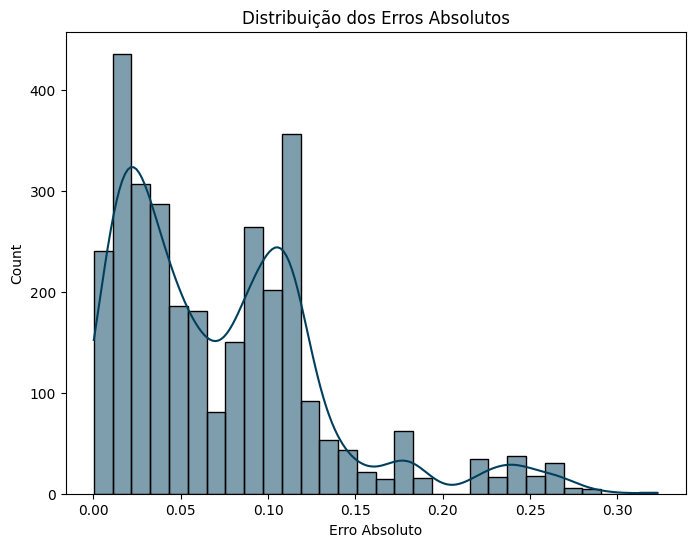

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

: 

In [ ]:
plot_residuals_vs_predictions(y_test, y_pred_ridge)
plot_residuals_distribution(y_test - y_pred_ridge)
plot_real_vs_predicted(y_test, y_pred_ridge)
plot_absolute_errors(y_test, y_pred_ridge)

## Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

# Validação cruzada com 5 folds
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"R² médio na validação cruzada: {cv_scores.mean()}")


R² médio na validação cruzada: 0.9358954116117013


: 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
degree = 3  # Grau do polinômio
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train_scaled)
X_test_poly = poly_features.transform(X_test_scaled)

# Treinamento do modelo Polinomial
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Predição nos dados de teste
y_pred_poly = poly_model.predict(X_test_poly)

# Obtendo as métricas
metrics_df_poly = regression_metrics('polinomial', y_test, y_pred_poly)
print(metrics_df_poly)

  metrics  value_metrics  name_model
0     MAE           0.00  polinomial
1     MSE           0.00  polinomial
2    RMSE           0.00  polinomial
3      R²           1.00  polinomial


: 

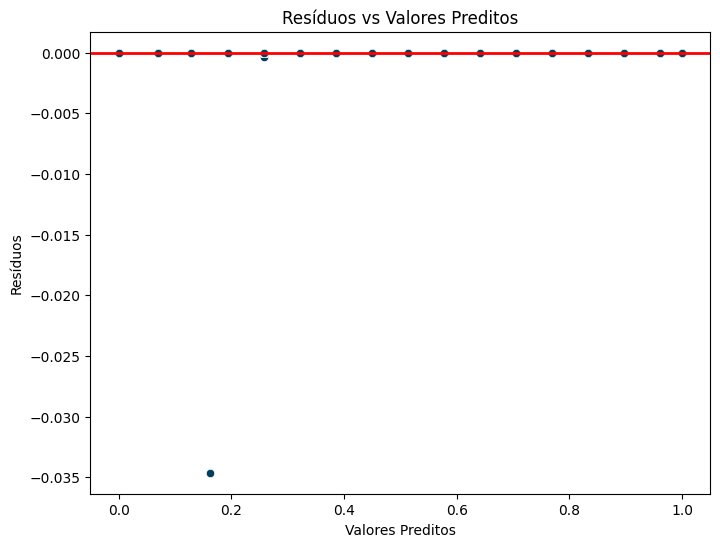

<Figure size 640x480 with 0 Axes>

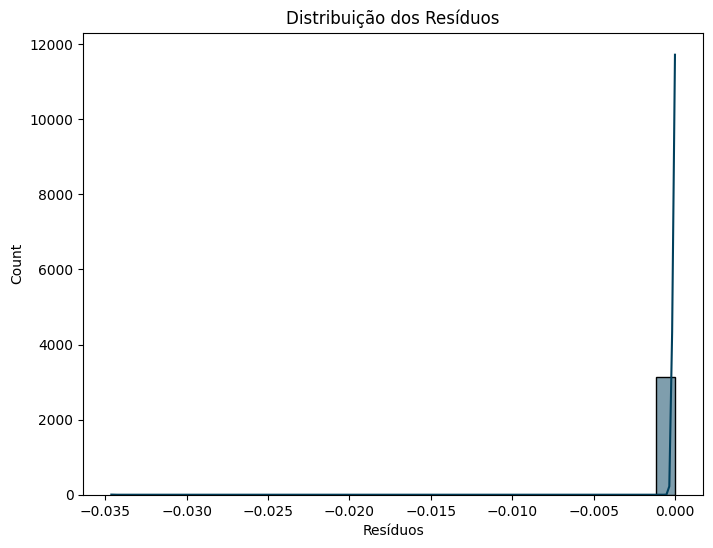

<Figure size 640x480 with 0 Axes>

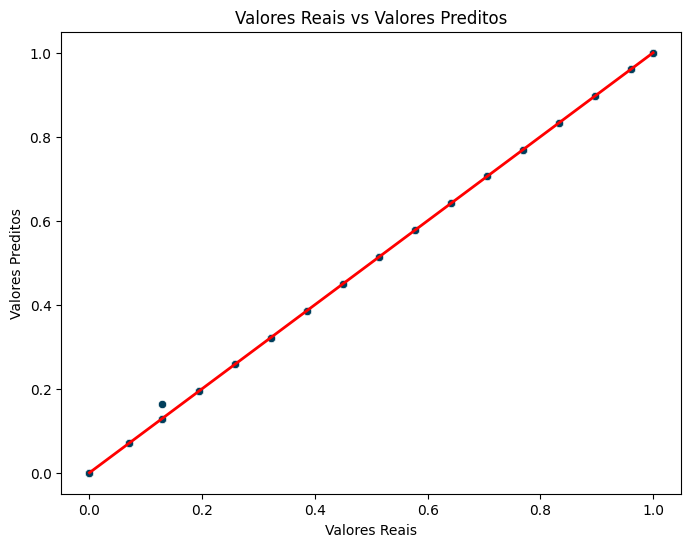

<Figure size 640x480 with 0 Axes>

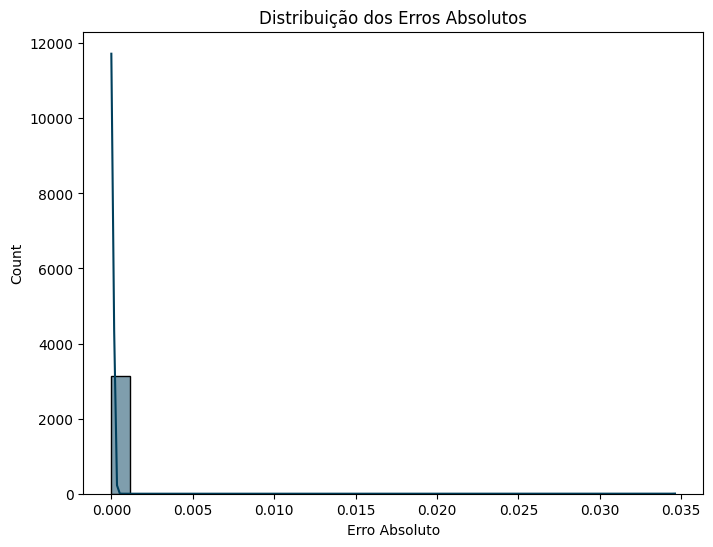

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

: 

In [ ]:
plot_residuals_vs_predictions(y_test, y_pred_poly)
plot_residuals_distribution(y_test - y_pred_poly)
plot_real_vs_predicted(y_test, y_pred_poly)
plot_absolute_errors(y_test, y_pred_poly)

: 